In [1]:
# import libraries
import pandas as pd
from scipy.optimize import minimize, least_squares
import numpy as np
import itertools
from scipy.integrate import quad
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("Project-Data.csv")
data.rename(columns={' ZCYield': 'ZCB Yield', ' FuturesPrice': 'FuturesPrice'}, inplace=True)


# Zero Coupon Bond Model

In [3]:
def b_r(lambda_r, tau):
    return (np.exp(-lambda_r * tau) - 1) / lambda_r

def b_0(lambda_r, tau, r_bar, sigma_r_norm=0.00023):
    term1 = -np.exp(-2 * lambda_r * tau) * (np.exp(lambda_r * tau) - 1) * ((3 * np.exp(lambda_r * tau) - 1) * sigma_r_norm**2 - 4 * np.exp(lambda_r * tau) * r_bar * lambda_r**2)
    term2 = 2 * (sigma_r_norm**2 - 2 * r_bar * lambda_r**2) * lambda_r * tau
    return (1 / (4 * lambda_r**3)) * (term1 + term2)

In [118]:
# Grid Search

lambda_r = np.linspace(0.05 ,1, 20)
r_0 = np.linspace(0.0005, 0.02, 40)
rb = np.linspace(0.0005, 0.02, 40)

best_MAPE = np.inf
best_params = None
params = list(itertools.product(lambda_r, r_0, rb))
for param in tqdm(params):
    lambda_, r0, r_bar = param
    data["b_r"] = b_r(lambda_, data["Maturity"])
    data["b_0"] = b_0(lambda_, data["Maturity"], r_bar)
    data["Yield Prediction"] = -1 / data["Maturity"] * (data["b_0"] + data["b_r"] * r0)
    MAPE = np.mean(np.abs((data["Yield Prediction"] - data["ZCB Yield"]) / data["ZCB Yield"])) * 100
    if MAPE < best_MAPE:
        best_MAPE = MAPE
        best_params = (lambda_, r0, r_bar)
    
print(f"Best MAPE: {best_MAPE}")
best_lambda_r, best_r0, best_r_bar = best_params
print(f"best lambda_r: {round(best_lambda_r, 4)}")
print(f"best r0: {round(best_r0, 4)}")
print(f"best r_bar: {round(best_r_bar, 4)}")

100%|██████████| 32000/32000 [01:47<00:00, 297.92it/s]

Best MAPE: 0.38649006840901773
best lambda_r: 0.2
best r0: 0.0145
best r_bar: 0.009


In [4]:
# Using optimizer

def calculate_mape(params, data):
    lambda_, r0, r_bar = params
    data["b_r"] = b_r(lambda_, data["Maturity"])
    data["b_0"] = b_0(lambda_, data["Maturity"], r_bar)
    data["Yield Prediction"] = -1 / data["Maturity"] * (data["b_0"] + data["b_r"] * r0)
    MAPE = np.mean(np.abs((data["Yield Prediction"] - data["ZCB Yield"]) / data["ZCB Yield"])) * 100
    return MAPE


# Initial guess for the parameters from the grid search
initial_guess = [0.2, 0.0145, 0.009]


# Use the minimize function
result = minimize(calculate_mape, initial_guess, args=(data,), method='Nelder-Mead')

# Get the best parameters
best_params = result.x
best_MAPE = result.fun

print(f"Best MAPE: {best_MAPE}")
best_lambda_r, best_r0, best_r_bar = best_params
print(f"best lambda_r: {round(best_lambda_r, 4)}")
print(f"best r0: {round(best_r0, 4)}")
print(f"best r_bar: {round(best_r_bar, 4)}")

Best MAPE: 0.2547196138571384
best lambda_r: 0.2593
best r0: 0.0145
best r_bar: 0.0098


Text(0.5, 1.0, 'Yield Real vs Prediction values')

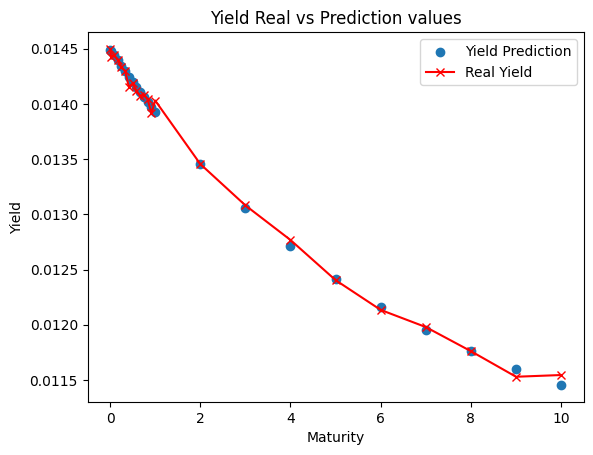

In [5]:
best_lambda, best_r0, best_r_bar = best_params
data["b_r"] = b_r(best_lambda, data["Maturity"])
data["b_0"] = b_0(best_lambda, data["Maturity"], best_r_bar)
data["Yield Prediction"] = -1 / data["Maturity"] * (data["b_0"] + data["b_r"] * best_r0)
plt.scatter(data["Maturity"], data["Yield Prediction"], label="Yield Prediction")
plt.plot(data['Maturity'],data["ZCB Yield"], label="Real Yield", color = 'r', marker = 'x')
plt.legend()
plt.xlabel("Maturity")
plt.ylabel("Yield")
plt.title("Yield Real vs Prediction values")

In [6]:
# Accuracy of the model
MAPE = np.mean(np.abs((data["Yield Prediction"] - data["ZCB Yield"]) / data["ZCB Yield"])) * 100
print(f"MAPE: {MAPE}")
MSE = np.mean((data["Yield Prediction"] - data["ZCB Yield"])**2)
print(f"MSE: {MSE}")
MAE = np.mean(np.abs(data["Yield Prediction"] - data["ZCB Yield"]))
print(f"MAE: {MAE}")

MAPE: 0.2547196138571384
MSE: 2.0653814840081518e-09
MAE: 3.3533051599989444e-05


# Futures Price Model

In [7]:
norm_sigma_r_sq = 0.000529 * 10**(-4)
norm_sigma_delta_sq = 0.000144 * 10**(-4)
norm_sigma_O_sq = 576 * 10**(-4)
dot_sigma_O_sigma_delta = 0.08352 * 10**(-4)
dot_sigma_O_sigma_r = 0.44712* 10**(-4)
dot_sigma_r_sigma_delta = 0.00003312 * 10**(-4)

quadratic_variation_matrix = np.array([[norm_sigma_r_sq, dot_sigma_O_sigma_r, dot_sigma_r_sigma_delta],
                                        [dot_sigma_O_sigma_r, norm_sigma_O_sq, dot_sigma_O_sigma_delta],
                                        [dot_sigma_r_sigma_delta, dot_sigma_O_sigma_delta, norm_sigma_delta_sq]])

correlation_matrix = np.array([[quadratic_variation_matrix[i, j] / np.sqrt(quadratic_variation_matrix[i, i] * quadratic_variation_matrix[j, j]) for j in range(3)] for i in range(3)])

In [8]:
# Grid search for the futures price model

# Function for phi_r
def phi_r(tau, lambda_r):
    return (1 - np.exp(-lambda_r * tau)) / lambda_r

# Function for phi_delta
def phi_delta(tau, lambda_delta):
    return (np.exp(-lambda_delta * tau) - 1) / lambda_delta

# Function for phi_0 with updated inputs
def phi_0(tau, lambda_r, lambda_delta, norm_sigma_r_sq, norm_sigma_delta_sq, dot_sigma_O_sigma_delta, dot_sigma_O_sigma_r, dot_sigma_r_sigma_delta, r_bar, delta_bar):
    def integrand(u):
        phi_r_u = phi_r(u, lambda_r)
        phi_delta_u = phi_delta(u, lambda_delta)
        term1 = 0.5 * norm_sigma_r_sq * (phi_r_u ** 2)
        term2 = phi_delta_u * (lambda_delta * delta_bar + dot_sigma_O_sigma_delta)
        term3 = 0.5 * norm_sigma_delta_sq * (phi_delta_u ** 2)
        term4 = phi_r_u * (lambda_r * r_bar + dot_sigma_O_sigma_r)
        term5 = phi_r_u * phi_delta_u * dot_sigma_r_sigma_delta
        return term1 + term2 + term3 + term4 + term5
    
    # Compute the integral for each value of tau
    result = np.array([quad(integrand, 0, t)[0] for t in tau])
    return result


In [129]:

# Example usage:

lambda_delta = np.linspace(0.05 ,1, 20)
delta_0 = np.linspace(0.001, 0.03, 30)
delta_bar = np.linspace(-0.01, 0.01, 20)
lambda_r = 0.2593
r0 = 0.0145
r_bar = 0.0098
 

params = list(itertools.product(lambda_delta, delta_0, delta_bar))
best_MAPE = np.inf
best_params = None


for param in tqdm(params):
    lambda_, delta0, delta_bar = param
    data["phi_0"] = phi_0(data["Maturity"].values, lambda_r, lambda_, norm_sigma_r_sq, norm_sigma_delta_sq, dot_sigma_O_sigma_delta, dot_sigma_O_sigma_r, dot_sigma_r_sigma_delta, r_bar, delta_bar)
    data["phi_r"] = phi_r(data["Maturity"].values, lambda_r)
    data["phi_delta"] = phi_delta(data["Maturity"].values, lambda_)
    data["Futures prediction"] = 80 *  np.exp(data["phi_0"] + data["phi_r"] * r0 + data["phi_delta"] * delta0)
    MAPE = np.mean(np.abs((data["Futures prediction"] - data["FuturesPrice"]) / data["FuturesPrice"])) * 100
    if MAPE < best_MAPE:
        best_MAPE = MAPE
        best_params = (lambda_, delta0, delta_bar)

print(f"Best MAPE: {best_MAPE}")
best_lambda_delta, best_delta0, best_delta_bar = best_params
print(f"best lambda_delta: {round(best_lambda_delta, 4)}")
print(f"best delta0: {round(best_delta0, 4)}")
print(f"best delta_bar: {round(best_delta_bar, 4)}")

100%|██████████| 12000/12000 [00:33<00:00, 354.47it/s]

Best MAPE: 0.04003051053391288
best lambda_delta: 0.55
best delta0: 0.02
best delta_bar: -0.01


In [9]:
# Using optimizer

def calculate_mape(params, data, lambda_r, r_bar, r0, norm_sigma_r_sq, norm_sigma_delta_sq, dot_sigma_O_sigma_delta, dot_sigma_O_sigma_r, dot_sigma_r_sigma_delta):
    lambda_delta, delta0, delta_bar = params
    data["phi_0"] = phi_0(data["Maturity"].values, lambda_r, lambda_delta, norm_sigma_r_sq, norm_sigma_delta_sq, dot_sigma_O_sigma_delta, dot_sigma_O_sigma_r, dot_sigma_r_sigma_delta, r_bar, delta_bar)
    data["phi_r"] = phi_r(data["Maturity"].values, lambda_r)
    data["phi_delta"] = phi_delta(data["Maturity"].values, lambda_delta)
    data["Futures prediction"] = 80 *  np.exp(data["phi_0"] + data["phi_r"] * r0 + data["phi_delta"] * delta0)
    MAPE = np.mean(np.abs((data["Futures prediction"] - data["FuturesPrice"]) / data["FuturesPrice"])) * 100
    return MAPE

# Initial guess for the parameters from the grid search
initial_guess = [0.55, 0.02, -0.01]

# Use the minimize function
result = minimize(calculate_mape, initial_guess, args=(data, best_lambda_r, best_r_bar, best_r0, norm_sigma_r_sq, norm_sigma_delta_sq, dot_sigma_O_sigma_delta, dot_sigma_O_sigma_r, dot_sigma_r_sigma_delta), method='Nelder-Mead')

# Get the best parameters
best_params = result.x
best_MAPE = result.fun

print(f"Best MAPE: {best_MAPE}")
best_lambda_delta, best_delta0, best_delta_bar = best_params
print(f"best lambda_delta: {round(best_lambda_delta, 4)}")
print(f"best delta0: {round(best_delta0, 4)}")
print(f"best delta_bar: {round(best_delta_bar, 4)}")

Best MAPE: 0.013266135326571829
best lambda_delta: 0.5247
best delta0: 0.0197
best delta_bar: -0.0102


Text(0.5, 1.0, 'Futures Price Real vs Prediction values')

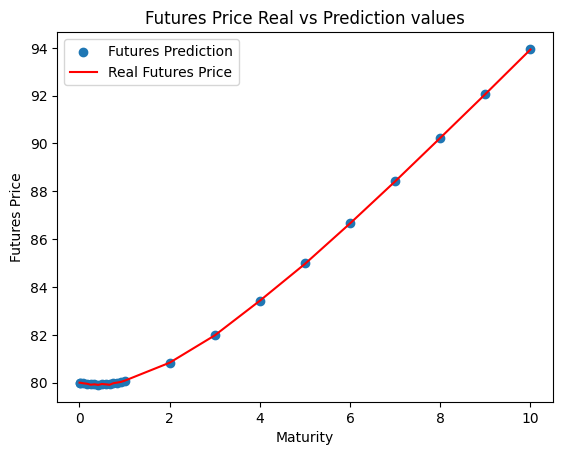

In [10]:
best_lambda_delta, best_delta0, best_delta_bar = best_params
data["phi_0"] = phi_0(data["Maturity"].values, best_lambda_r, best_lambda_delta, norm_sigma_r_sq, norm_sigma_delta_sq, dot_sigma_O_sigma_delta, dot_sigma_O_sigma_r, dot_sigma_r_sigma_delta, best_r_bar, best_delta_bar)
data["phi_r"] = phi_r(data["Maturity"].values, best_lambda_r)
data["phi_delta"] = phi_delta(data["Maturity"].values, best_lambda_delta)
data["Futures prediction"] = 80 *  np.exp(data["phi_0"] + data["phi_r"] * best_r0 + data["phi_delta"] * best_delta0)
plt.scatter(data["Maturity"], data["Futures prediction"], label="Futures Prediction")
plt.plot(data['Maturity'],data["FuturesPrice"], label="Real Futures Price", color = 'r')
plt.legend()
plt.xlabel("Maturity")
plt.ylabel("Futures Price")
plt.title("Futures Price Real vs Prediction values")


In [11]:
# Accuracy of the model
MAPE = np.mean(np.abs((data["Futures prediction"] - data["FuturesPrice"]) / data["FuturesPrice"])) * 100
print(f"MAPE: {MAPE}")
MSE = np.mean((data["Futures prediction"] - data["FuturesPrice"])**2)
print(f"MSE: {MSE}")
MAE = np.mean(np.abs(data["Futures prediction"] - data["FuturesPrice"]))
print(f"MAE: {MAE}")

MAPE: 0.013266135326571829
MSE: 0.00023988653917799907
MAE: 0.010974212014634487


# Storage options

In [12]:
import numpy as np

def psi_delta(Delta, lambda_delta):
    return (1 / lambda_delta) * (np.exp(-lambda_delta * Delta) - 1)


def psi_0(Delta, lambda_delta, sigma_delta_norm_sq, delta_bar, sigma_O_T_sigma_delta):
    term1 = np.exp(-2 * lambda_delta * Delta)
    term2 = (np.exp(lambda_delta * Delta) - 1)
    term3 = (3 * np.exp(lambda_delta * Delta) - 1) * sigma_delta_norm_sq
    term4 = -4 * np.exp(
        lambda_delta * Delta) * delta_bar * lambda_delta**2
    term5 = -4 * np.exp(lambda_delta * Delta) * lambda_delta * sigma_O_T_sigma_delta
    term6 = 2 * lambda_delta * Delta * (sigma_delta_norm_sq - 2 * delta_bar * lambda_delta**2 - 2 * lambda_delta * sigma_O_T_sigma_delta)
    
    result = (1 / (4 * lambda_delta**3)) * (-term1 * term2 * (term3 + term4 + term5) + term6)
    
    return result


In [13]:
def H(delta_T0, Delta, alpha, lambda_delta, norm_sigma_delta_sq, delta_bar, dot_sigma_O_sigma_delta):
    term1 = np.exp(psi_0(Delta, lambda_delta, norm_sigma_delta_sq, delta_bar, dot_sigma_O_sigma_delta) + psi_delta(Delta, lambda_delta) * delta_T0) - 1
    integral, _ = quad(lambda z: np.exp(psi_0(z, lambda_delta, norm_sigma_delta_sq, delta_bar, dot_sigma_O_sigma_delta) + psi_delta(z, lambda_delta) * delta_T0), 0, Delta)
    term2 = alpha * integral
    return term1 - term2 

def calculate_storage_value(Delta, alpha, lambda_delta, norm_sigma_delta_sq, delta_bar, dot_sigma_O_sigma_delta):
    integral, _ = quad(lambda z: np.exp(psi_0(z, lambda_delta, norm_sigma_delta_sq, delta_bar, dot_sigma_O_sigma_delta)), 0, Delta)
    storage_value = alpha * integral
    return storage_value

In [14]:
# function for generating correlated Brownian motion
def generate_correlated_bm(T, n, corr_matrix):
    dt = T / n
    L = np.linalg.cholesky(corr_matrix)
    dW = np.random.normal(0, np.sqrt(dt), (n, 3))
    dW_correlated = dW @ L.T
    W1 = np.cumsum(dW_correlated[:, 0])
    W2 = np.cumsum(dW_correlated[:, 1])
    W3 = np.cumsum(dW_correlated[:, 2])
    return W1, W2, W3

# function for creating random paths for Stock Price, Interest Rate, and Convenience Yield
def create_random_paths(N, n, T, r0, lambda_r, r_bar, delta0, lambda_delta, delta_bar, O0, quad_var_matrix, corr_matrix):
    dt = T / n
    all_paths = {'O_t': [], 'r_t': [], 'delta_t': []}
    
    for j in range(N):
        W_r, W_O, W_delta = generate_correlated_bm(T, n, corr_matrix)
        
        # Initialize arrays for O_t, r_t, and delta_t
        O_t = np.zeros(n)
        r_t = np.zeros(n)
        delta_t = np.zeros(n)
        O_t[0] = O0
        r_t[0] = r0
        delta_t[0] = delta0
        
        # Simulate the paths
        for i in range(1, n):
            dW_O = W_O[i] - W_O[i-1]
            dW_r = W_r[i] - W_r[i-1]
            dW_delta = W_delta[i] - W_delta[i-1]
            
            O_t[i] = O_t[i-1] * (1 + (r_t[i-1] - delta_t[i-1]) * dt + quad_var_matrix[1, 1] ** 0.5 * dW_O)
            r_t[i] = r_t[i-1] + lambda_r * (r_bar - r_t[i-1]) * dt + quad_var_matrix[0, 0] ** 0.5 * dW_r
            delta_t[i] = delta_t[i-1] + lambda_delta * (delta_bar - delta_t[i-1]) * dt + quad_var_matrix[2, 2] ** 0.5 * dW_delta
        
        all_paths['O_t'].append(O_t)
        all_paths['r_t'].append(r_t)
        all_paths['delta_t'].append(delta_t)

    return all_paths

In [35]:
from scipy.optimize import brentq

def calculate_H_and_price_and_critical_yield(all_paths, Delta, alpha, lambda_delta, norm_sigma_delta_sq, delta_bar, dot_sigma_O_sigma_delta, T_0):
    Prices = []
    Payoffs = []
    Storage_Dependence = []
    for i in range(len(all_paths['delta_t'])):
        O_T0 = all_paths['O_t'][i][int(T_0 / (T_0 + Delta) * 1000)]
        delta_T0 = all_paths['delta_t'][i][int(T_0/(T_0 + Delta) * 1000)]
        h_value = H(delta_T0, Delta, alpha, lambda_delta, norm_sigma_delta_sq, delta_bar, dot_sigma_O_sigma_delta)
        storage_value = calculate_storage_value(Delta, alpha, lambda_delta, norm_sigma_delta_sq, delta_bar, dot_sigma_O_sigma_delta)
        storage_value = storage_value * O_T0
        Storage_Dependence.append(storage_value)
        payoff = max(0, h_value * O_T0)
        delta_r = all_paths['r_t'][i]
        price = np.exp(-np.trapz(delta_r[:int(T_0 / (T_0 + Delta) * 1000 )]) * (T_0 + Delta) / 1000)  * max(h_value, 0) * O_T0
        Payoffs.append(payoff)
        Prices.append(price)
    price = np.mean(Prices)
    payoff = np.mean(Payoffs)
    storage_value = np.mean(Storage_Dependence)
    def H_delta_T0(delta_T0):
        return H(delta_T0, Delta, alpha, lambda_delta, norm_sigma_delta_sq, delta_bar, dot_sigma_O_sigma_delta)
    # Define the interval for delta_T0
    delta_T0_interval = [-5, 5]
    
    # Find the root of the function H_delta_T0 in the interval
    delta_T0_root = brentq(H_delta_T0, *delta_T0_interval)
    return payoff , price , delta_T0_root, storage_value

In [58]:
T1 = 0.75
T_0 = 0.5
alpha = 0.01
number_of_points_in_one_path = (T1 - T_0) * 1000

In [48]:
all_paths = create_random_paths(1000, 1000, T1, best_r0, best_lambda_r, best_r_bar, best_delta0, best_lambda_delta, best_delta_bar, 80, quadratic_variation_matrix, correlation_matrix)

In [46]:
payoff, price , critical_yield, storage_value = calculate_H_and_price_and_critical_yield(all_paths, T1 - T_0, alpha, best_lambda_delta, norm_sigma_delta_sq, best_delta_bar, dot_sigma_O_sigma_delta, T_0)

print("Values for best parameters")
print(f"Price of the option: {price}")
print(f"payoff: {payoff}")
print(f"Critical yield: {critical_yield}")
print(f"Storage value: {storage_value}")

Values for best parameters
Price of the option: 0.0
payoff: 0.0
Critical yield: 0.0016170135351609427
Storage value: 0.08132422366434057


## Sensitivity Analysis to different parameters

Text(0.5, 1.0, 'Critical Yield')

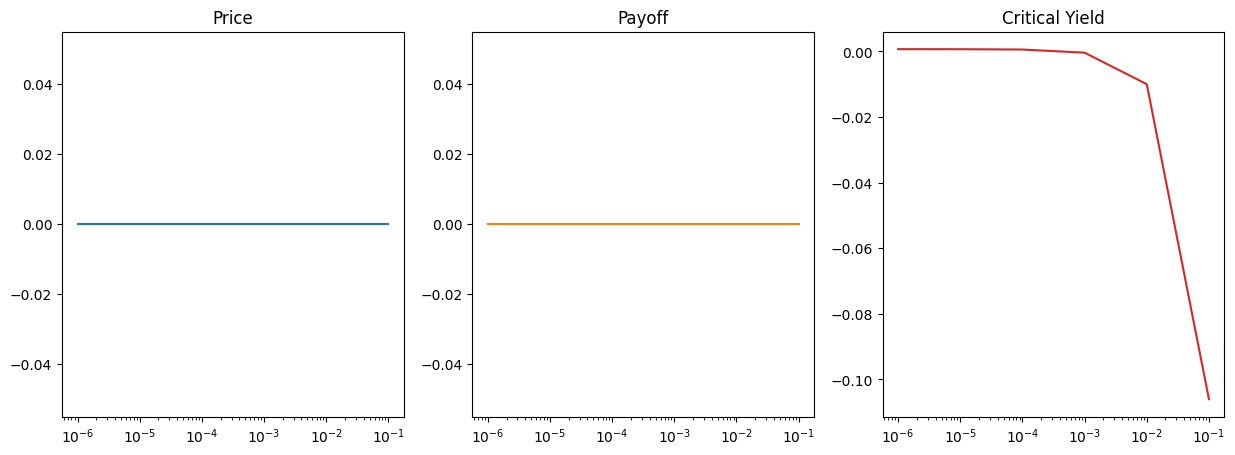

In [59]:
alpha_ranges = [10 ** i for i in range(-6,0)]
list_of_prices = []
list_of_payoffs = []
list_of_storage_values = []
list_of_critical_yields = []
all_paths = create_random_paths(1000, 1000, T1, best_r0, best_lambda_r, best_r_bar, best_delta0, best_lambda_delta, best_delta_bar, 80, quadratic_variation_matrix, correlation_matrix)
for alpha_samples in alpha_ranges:
    payoff, price , critical_yield, storage_value = calculate_H_and_price_and_critical_yield(all_paths, T1 - T_0, alpha_samples, best_lambda_delta, norm_sigma_delta_sq, best_delta_bar, dot_sigma_O_sigma_delta, T_0)
    list_of_prices.append(price)
    list_of_payoffs.append(payoff)
    list_of_storage_values.append(storage_value)
    list_of_critical_yields.append(critical_yield)
    
# do a subplot for each of the values
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].semilogx(alpha_ranges, list_of_prices)
axs[0].set_title('Price')
axs[1].semilogx(alpha_ranges, list_of_payoffs, 'tab:orange')
axs[1].set_title('Payoff')
axs[2].semilogx(alpha_ranges, list_of_critical_yields, 'tab:red')
axs[2].set_title('Critical Yield')

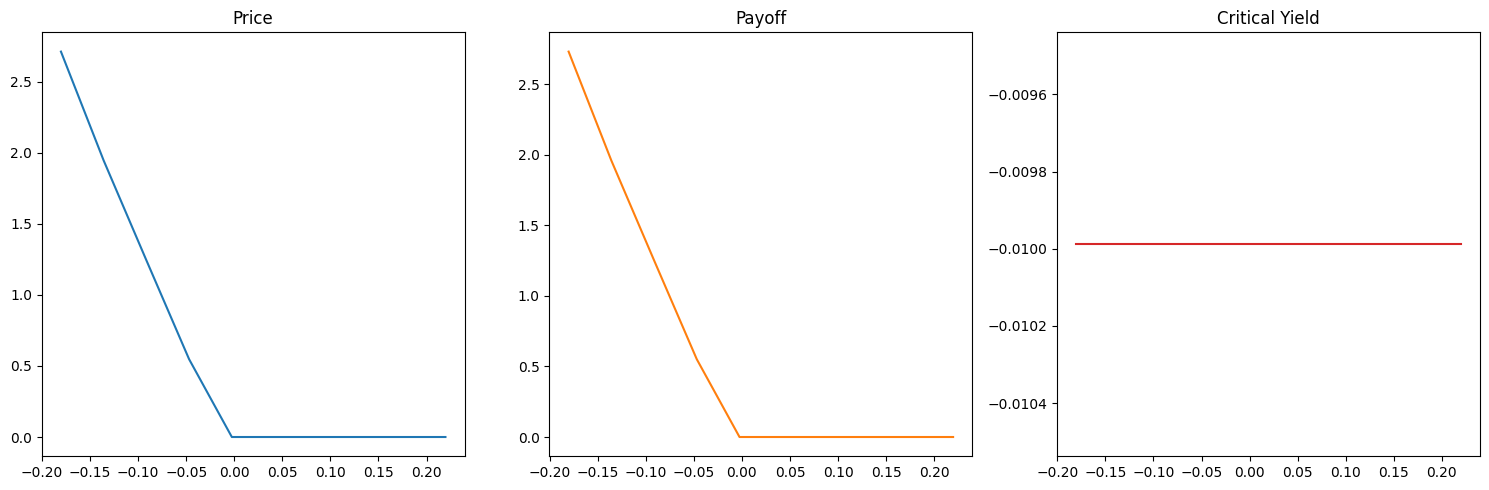

In [70]:
delta0_ranges = np.linspace(best_delta0 - 0.2, best_delta0 + 0.2, 10)
list_of_prices = []
list_of_payoffs = []
list_of_storage_values = []
list_of_critical_yields = []
for delta0_samples in delta0_ranges:
    all_paths = create_random_paths(1000, 1000, T1, best_r0, best_lambda_r, best_r_bar, delta0_samples, best_lambda_delta, best_delta_bar, 80, quadratic_variation_matrix, correlation_matrix)
    payoff, price , critical_yield, storage_value = calculate_H_and_price_and_critical_yield(all_paths, T1 - T_0, alpha, best_lambda_delta, norm_sigma_delta_sq, best_delta_bar, dot_sigma_O_sigma_delta, T_0)
    list_of_prices.append(price)
    list_of_payoffs.append(payoff)
    list_of_storage_values.append(storage_value)
    list_of_critical_yields.append(critical_yield)

# do a subplot for each of the values
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the data
axs[0].plot(delta0_ranges, list_of_prices)
axs[0].set_title('Price')

axs[1].plot(delta0_ranges, list_of_payoffs, 'tab:orange')
axs[1].set_title('Payoff')

axs[2].plot(delta0_ranges, list_of_critical_yields, 'tab:red')
axs[2].set_title('Critical Yield')

# Display the plot
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Critical Yields')

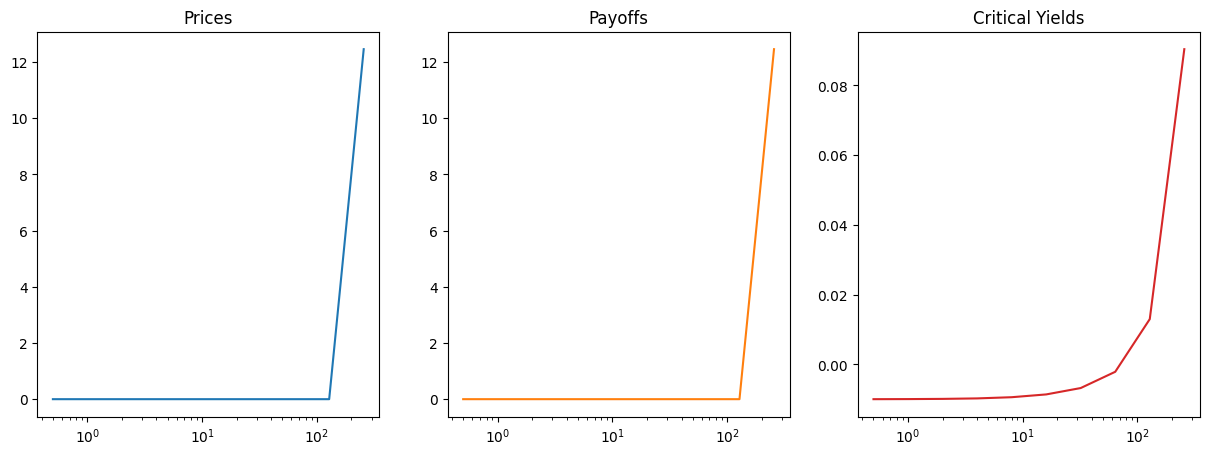

In [62]:
Delta_ranges = [0.5, 1,2,4,8,16,32,64, 128, 256]
list_of_prices = []
list_of_payoffs = []
list_of_storage_values = []
list_of_critical_yields = []
for Delta_samples in Delta_ranges:
    T1_new = T_0 + Delta_samples
    all_paths = create_random_paths(1000, 1000, T1_new, best_r0, best_lambda_r, best_r_bar, best_delta0, best_lambda_delta, best_delta_bar, 80, quadratic_variation_matrix, correlation_matrix)
    payoff, price , critical_yield, storage_value = calculate_H_and_price_and_critical_yield(all_paths, T1_new- T_0, alpha, best_lambda_delta, norm_sigma_delta_sq, best_delta_bar, dot_sigma_O_sigma_delta, T_0)
    list_of_prices.append(price)
    list_of_payoffs.append(payoff)
    list_of_storage_values.append(storage_value)
    list_of_critical_yields.append(critical_yield)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].semilogx(Delta_ranges, list_of_prices)
axs[0].set_title('Prices')
axs[1].semilogx(Delta_ranges, list_of_payoffs, 'tab:orange')
axs[1].set_title('Payoffs')
axs[2].semilogx(Delta_ranges, list_of_critical_yields, 'tab:red')
axs[2].set_title('Critical Yields')

Text(0.5, 1.0, 'Critical Yield')

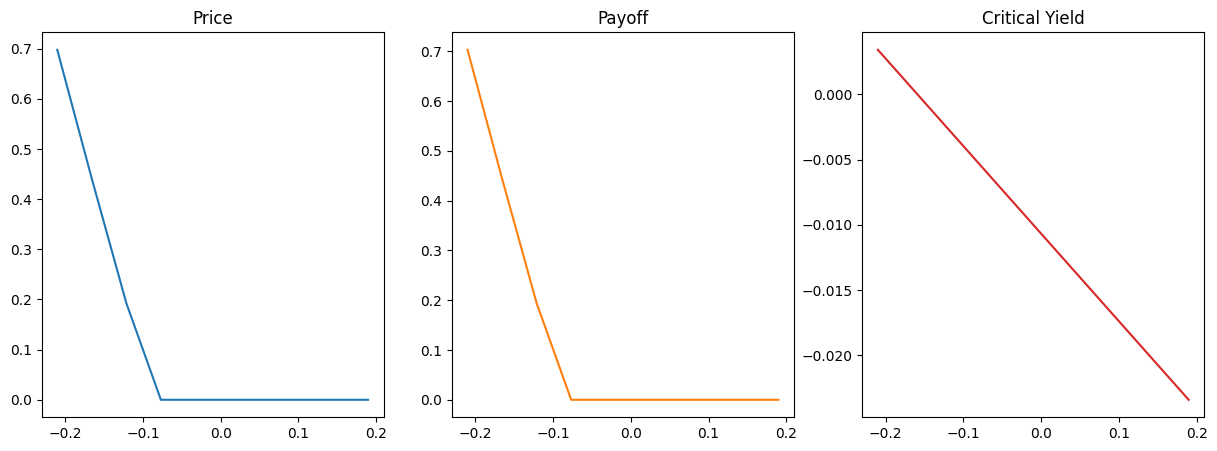

In [69]:
delta_bar_ranges = np.linspace(best_delta_bar - 0.2, best_delta_bar + 0.2, 10)
list_of_prices = []
list_of_payoffs = []
list_of_storage_values = []
list_of_critical_yields = []
for delta_bar_samples in delta_bar_ranges:
    all_paths = create_random_paths(1000, 1000, T1, best_r0, best_lambda_r, best_r_bar, best_delta0, best_lambda_delta, delta_bar_samples, 80, quadratic_variation_matrix, correlation_matrix)
    payoff, price , critical_yield, storage_value = calculate_H_and_price_and_critical_yield(all_paths, T1 - T_0, alpha, best_lambda_delta, norm_sigma_delta_sq, delta_bar_samples, dot_sigma_O_sigma_delta, T_0)
    list_of_prices.append(price)
    list_of_payoffs.append(payoff)
    list_of_storage_values.append(storage_value)
    list_of_critical_yields.append(critical_yield)
    
# do a subplot for each of the values
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].plot(delta_bar_ranges, list_of_prices)
axs[0].set_title('Price')
axs[1].plot(delta_bar_ranges, list_of_payoffs, 'tab:orange')
axs[1].set_title('Payoff')
axs[2].plot(delta_bar_ranges, list_of_critical_yields, 'tab:red')
axs[2].set_title('Critical Yield')

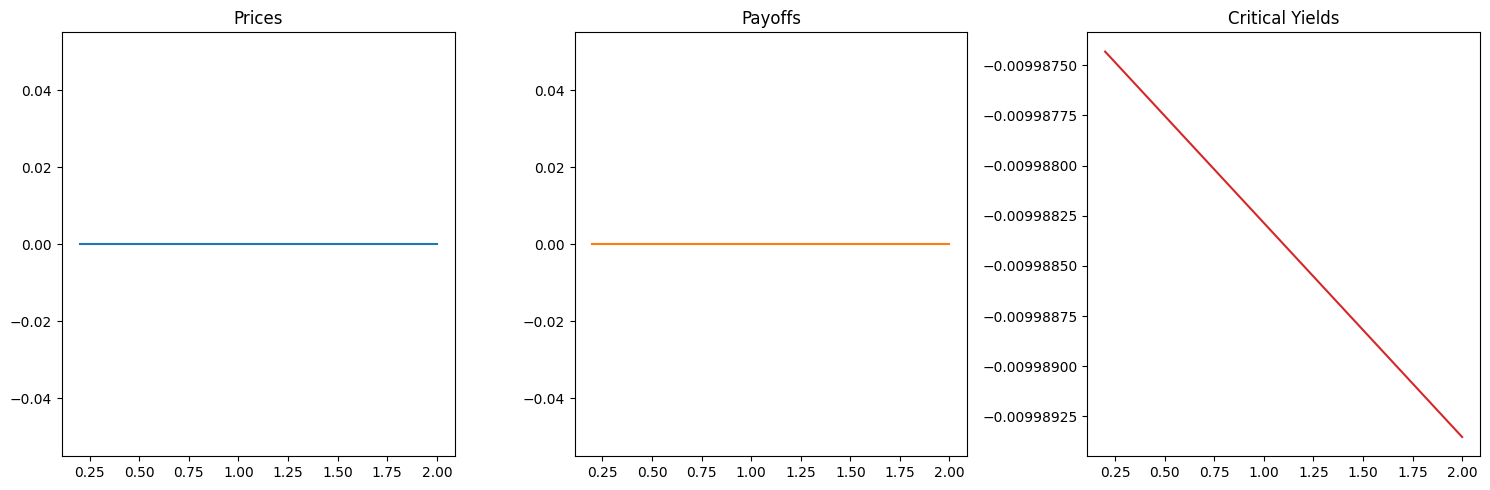

In [76]:
multiplying_factor_for_correlation = np.linspace(0.2, 3, 10)
list_of_prices = []
list_of_payoffs = []
list_of_storage_values = []
list_of_critical_yields = []
for factor in multiplying_factor_for_correlation:
    quadratic_variation_matrix_sample = quadratic_variation_matrix.copy()
    quadratic_variation_matrix_sample[1,2] = quadratic_variation_matrix_sample[1,2] * factor
    quadratic_variation_matrix_sample[2,1] = quadratic_variation_matrix_sample[2,1] * factor
    dot_sigma_O_sigma_delta_sample = dot_sigma_O_sigma_delta * factor
    correlation_matrix_sample = np.array([[quadratic_variation_matrix_sample[i, j] / np.sqrt(quadratic_variation_matrix_sample[i, i] * quadratic_variation_matrix_sample[j, j]) for j in range(3)] for i in range(3)])
    all_paths = create_random_paths(1000, 1000, T1, best_r0, best_lambda_r, best_r_bar, best_delta0, best_lambda_delta, best_delta_bar, 80, quadratic_variation_matrix_sample, correlation_matrix_sample)
    payoff, price , critical_yield, storage_value = calculate_H_and_price_and_critical_yield(all_paths, T1 - T_0, alpha, best_lambda_delta, norm_sigma_delta_sq, best_delta_bar, dot_sigma_O_sigma_delta_sample, T_0)
    list_of_prices.append(price)
    list_of_payoffs.append(payoff)
    list_of_storage_values.append(storage_value)
    list_of_critical_yields.append(critical_yield)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].plot(multiplying_factor_for_correlation * correlation_matrix[1,2], list_of_prices)
axs[0].set_title('Prices')
axs[1].plot(multiplying_factor_for_correlation * correlation_matrix[1,2], list_of_payoffs, 'tab:orange')
axs[1].set_title('Payoffs')
axs[2].plot(multiplying_factor_for_correlation * correlation_matrix[1,2], list_of_critical_yields, 'tab:red')
axs[2].set_title('Critical Yields')

Text(0.5, 1.0, 'Critical Yields')

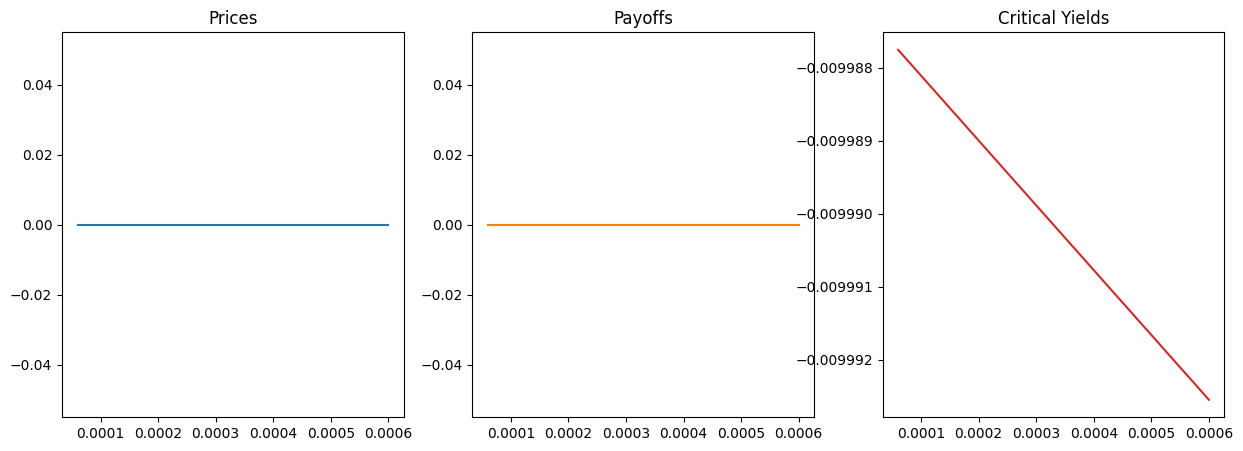

In [81]:
multiplying_factor_for_norm_delta = np.linspace(0.5, 5, 10)
list_of_prices = []
list_of_payoffs = []
list_of_storage_values = []
list_of_critical_yields = []
for factor in multiplying_factor_for_norm_delta:
    quadratic_variation_matrix_sample = quadratic_variation_matrix.copy()
    quadratic_variation_matrix_sample[2,2] = quadratic_variation_matrix_sample[2,2] * factor ** 2
    quadratic_variation_matrix_sample[1,2] = quadratic_variation_matrix_sample[1,2] * factor
    quadratic_variation_matrix_sample[2,1] = quadratic_variation_matrix_sample[2,1] * factor
    quadratic_variation_matrix_sample[0,2] = quadratic_variation_matrix_sample[0,2] * factor
    quadratic_variation_matrix_sample[2,0] = quadratic_variation_matrix_sample[2,0] * factor
    dot_sigma_O_sigma_delta_sample = dot_sigma_O_sigma_delta * factor
    dot_sigma_r_sigma_delta_sample = dot_sigma_r_sigma_delta * factor
    norm_sigma_delta_sq_sample = norm_sigma_delta_sq * factor ** 2
    correlation_matrix_sample = np.array([[quadratic_variation_matrix_sample[i, j] / np.sqrt(quadratic_variation_matrix_sample[i, i] * quadratic_variation_matrix_sample[j, j]) for j in range(3)] for i in range(3)])
    all_paths = create_random_paths(1000, 1000, T1, best_r0, best_lambda_r, best_r_bar, best_delta0, best_lambda_delta, best_delta_bar, 80, quadratic_variation_matrix_sample, correlation_matrix_sample)
    payoff, price , critical_yield, storage_value = calculate_H_and_price_and_critical_yield(all_paths, T1 - T_0, alpha, best_lambda_delta, norm_sigma_delta_sq_sample, best_delta_bar, dot_sigma_O_sigma_delta_sample, T_0)
    list_of_prices.append(price)
    list_of_payoffs.append(payoff)
    list_of_storage_values.append(storage_value)
    list_of_critical_yields.append(critical_yield)


fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].plot(multiplying_factor_for_norm_delta * quadratic_variation_matrix[2,2] ** 0.5, list_of_prices)
axs[0].set_title('Prices')
axs[1].plot(multiplying_factor_for_norm_delta * quadratic_variation_matrix[2,2] ** 0.5, list_of_payoffs, 'tab:orange')
axs[1].set_title('Payoffs')
axs[2].plot(multiplying_factor_for_norm_delta * quadratic_variation_matrix[2,2] ** 0.5, list_of_critical_yields, 'tab:red')
axs[2].set_title('Critical Yields')